# Chest X-Ray (Pneumonia): Image Classification w/Convolutional Neural Networks and Transfer Learning

# Overview

The objective of this notebook is to develop and evaluate Convolutional Neural Network (CNN) models for the classification of Chest X-Ray images, specifically distinguishing between healthy patients and those with pneumonia.

Kaggle Dataset Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

## Content
- Dataset Information  
- Importing Packages and Dataset  
- Data Exploration  
- Data Preparation
- Custom Model
- Transfer Learning
    - ResNet
    - VGG
- Explainability
- Potential of the model
- Steps for Clinical Integration

## Dataset Information

This dataset contains 5,856 validated Chest X-Ray images. The images are split into a training set and a testing set of independent patients. Images are labeled as (disease:NORMAL/BACTERIA/VIRUS)-(randomized patient ID)-(image number of a patient).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

The dataset is organised organized into training and testing folders. Training consist of 5232 images while the testing consist of 624 images.

## Importing Packages and Dataset

In [218]:
import pandas as pd       
import matplotlib as mlp
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
from IPython.display import Image, display
import matplotlib.cm as cm

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

import glob
import cv2
from collections import Counter

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix,\
      roc_auc_score, ConfusionMatrixDisplay, roc_curve

In [2]:
# Ensure TensorFlow uses the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow is using the GPU.")
    except RuntimeError as e:
        print(e)
else:
    print("TensorFlow is not using the GPU. Check your TensorFlow installation.")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow is using the GPU.


In [3]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [4]:
main_path = "../Data/chest_xray"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [5]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [6]:
df_train

class  \
0        Normal   
1        Normal   
2        Normal   
3        Normal   
4        Normal   
...         ...   
5227  Pneumonia   
5228  Pneumonia   
5229  Pneumonia   
5230  Pneumonia   
5231  Pneumonia   

                                                                image  
0           ../Data/chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg  
1           ../Data/chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg  
2                   ../Data/chest_xray/train/NORMAL/IM-0427-0001.jpeg  
3           ../Data/chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg  
4              ../Data/chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg  
...                                                               ...  
5227      ../Data/chest_xray/train/PNEUMONIA/person142_virus_288.jpeg  
5228  ../Data/chest_xray/train/PNEUMONIA/person364_bacteria_1659.jpeg  
5229    ../Data/chest_xray/train/PNEUMONIA/person1323_virus_2283.jpeg  
5230     ../Data/chest_xray/train/PNEUMONIA/person772_virus_1401.jpeg  
5231     ../Data/chest_xray/train/PNEUMONIA/person501_virus_1010.jpeg  

[5232 rows x 2 columns]

In [7]:
df_test

class                                                          image
0       Normal               ../Data/chest_xray/test/NORMAL/IM-0031-0001.jpeg
1       Normal               ../Data/chest_xray/test/NORMAL/IM-0025-0001.jpeg
2       Normal       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0272-0001.jpeg
3       Normal       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0102-0001.jpeg
4       Normal       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg
..         ...                                                            ...
619  Pneumonia  ../Data/chest_xray/test/PNEUMONIA/person120_bacteria_572.jpeg
620  Pneumonia  ../Data/chest_xray/test/PNEUMONIA/person171_bacteria_826.jpeg
621  Pneumonia  ../Data/chest_xray/test/PNEUMONIA/person109_bacteria_512.jpeg
622  Pneumonia   ../Data/chest_xray/test/PNEUMONIA/person83_bacteria_410.jpeg
623  Pneumonia  ../Data/chest_xray/test/PNEUMONIA/person112_bacteria_538.jpeg

[624 rows x 2 columns]

## Data Exploration

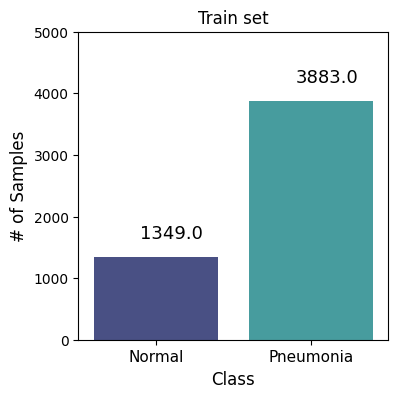

In [8]:
plt.figure(figsize=(4,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.title('Train set')
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

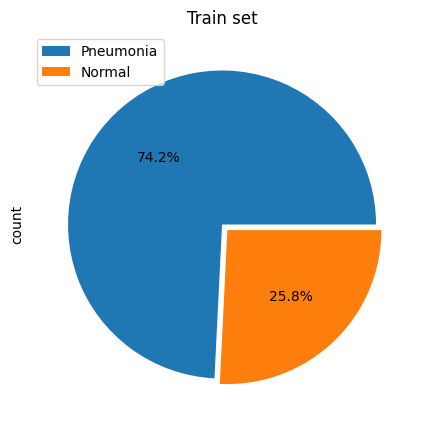

In [9]:
plt.figure(figsize=(5,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', explode = [0,0.05])
plt.title('Train set')
plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

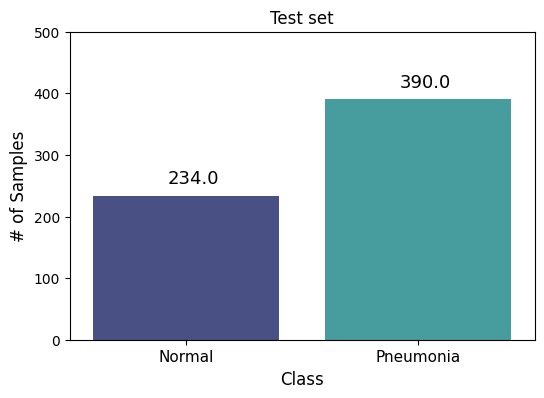

In [10]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.title('Test set')
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

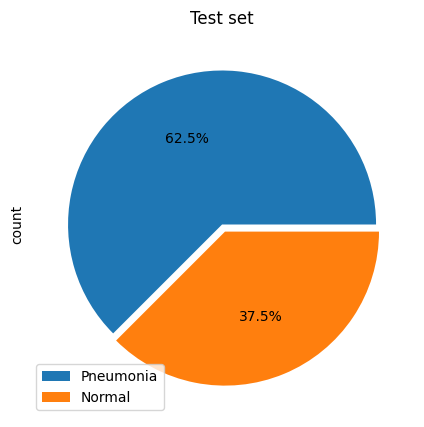

In [11]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', explode = [0,0.05])
plt.title('Test set')
plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

The distributions from these datasets are a little different from each other. Both are slightly imbalanced, having more samples from the positive class (Pneumonia), with the training set being a little more imbalanced.

Before we move on to the next section, we will take a look at a few examples from each dataset.

Train Set - Normal


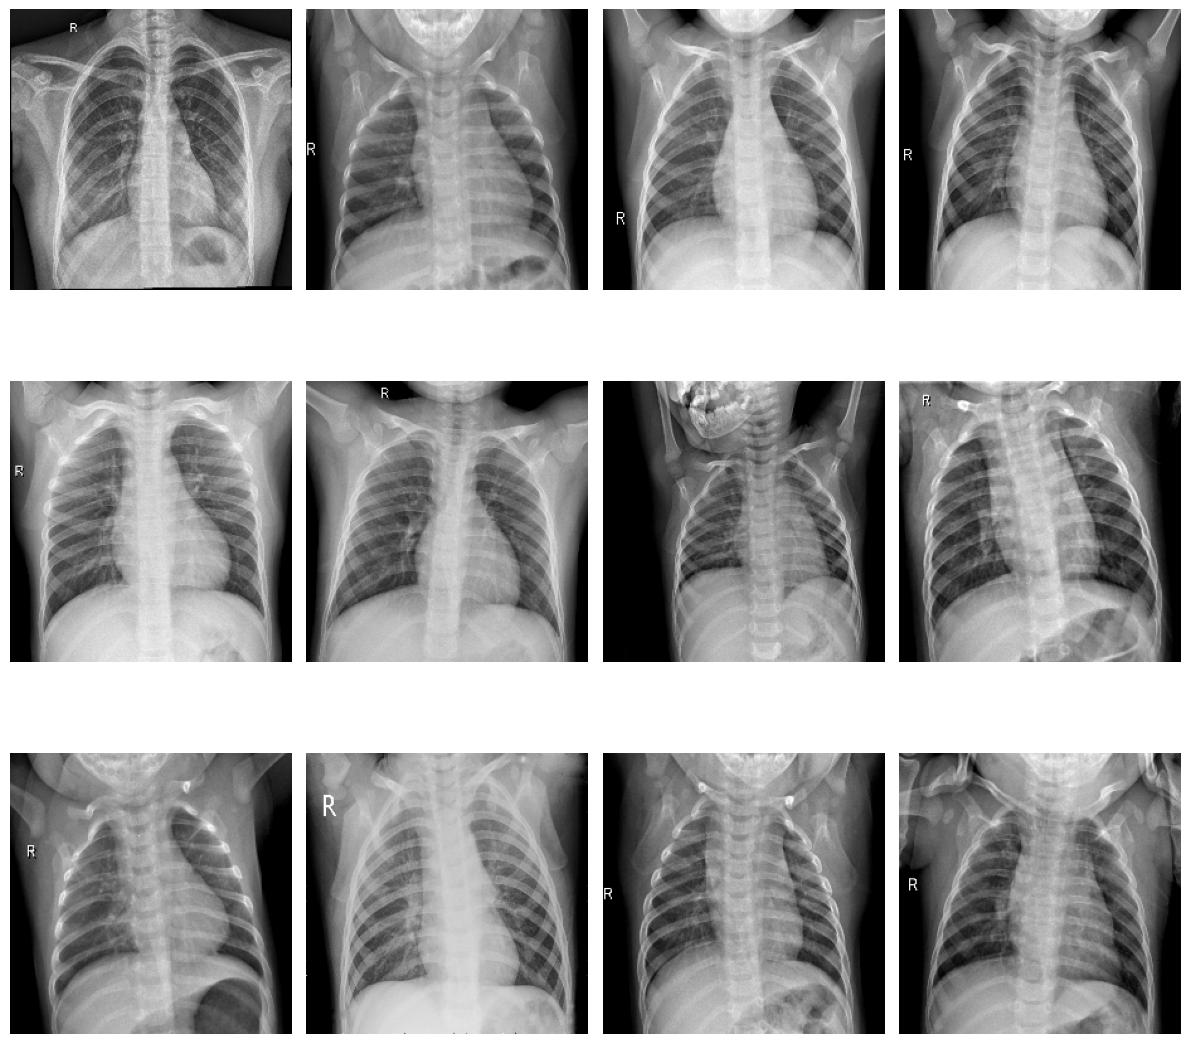

In [12]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - Pneumonia


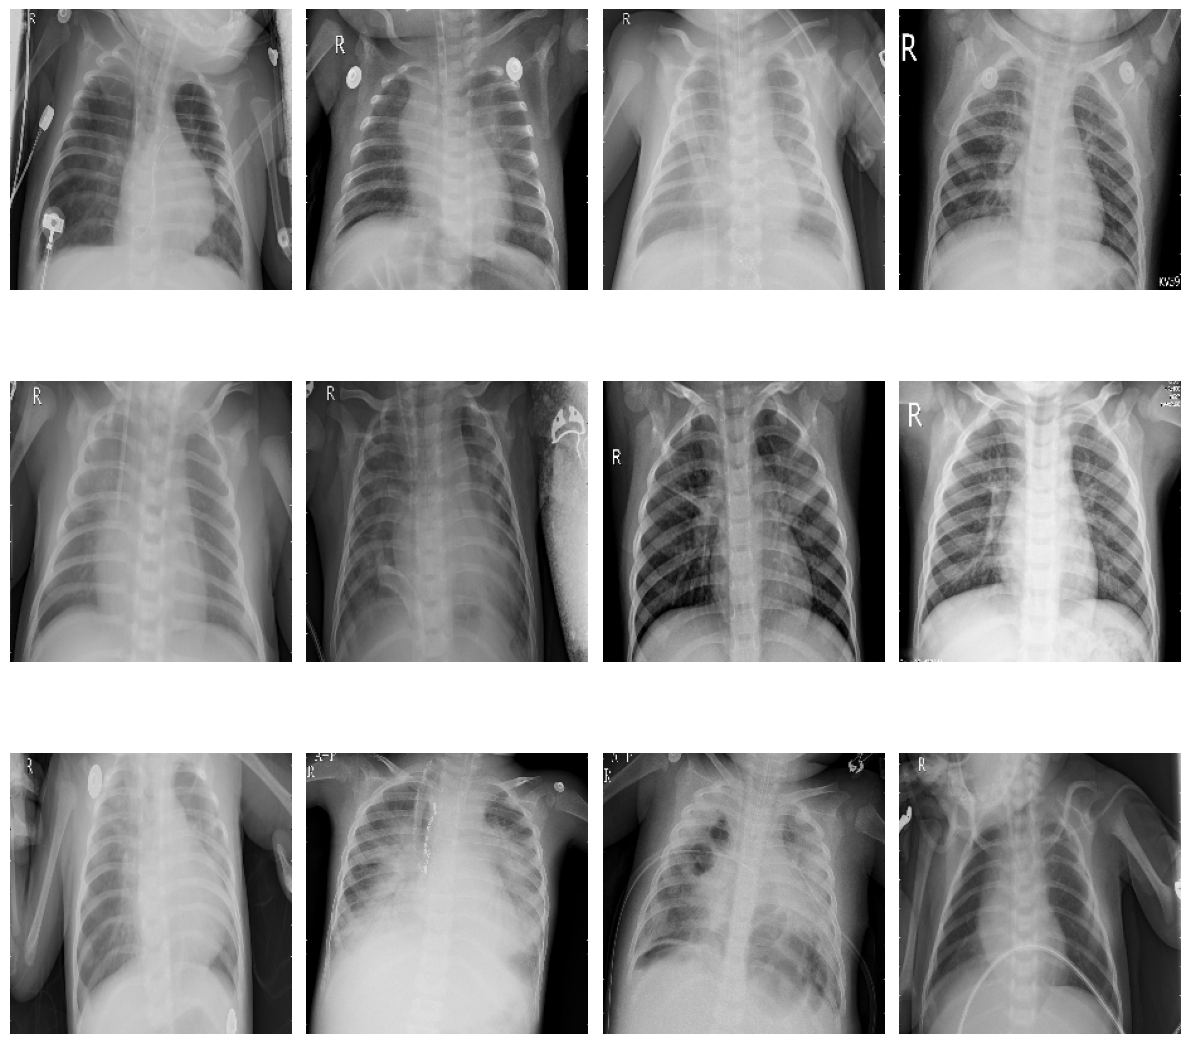

In [13]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


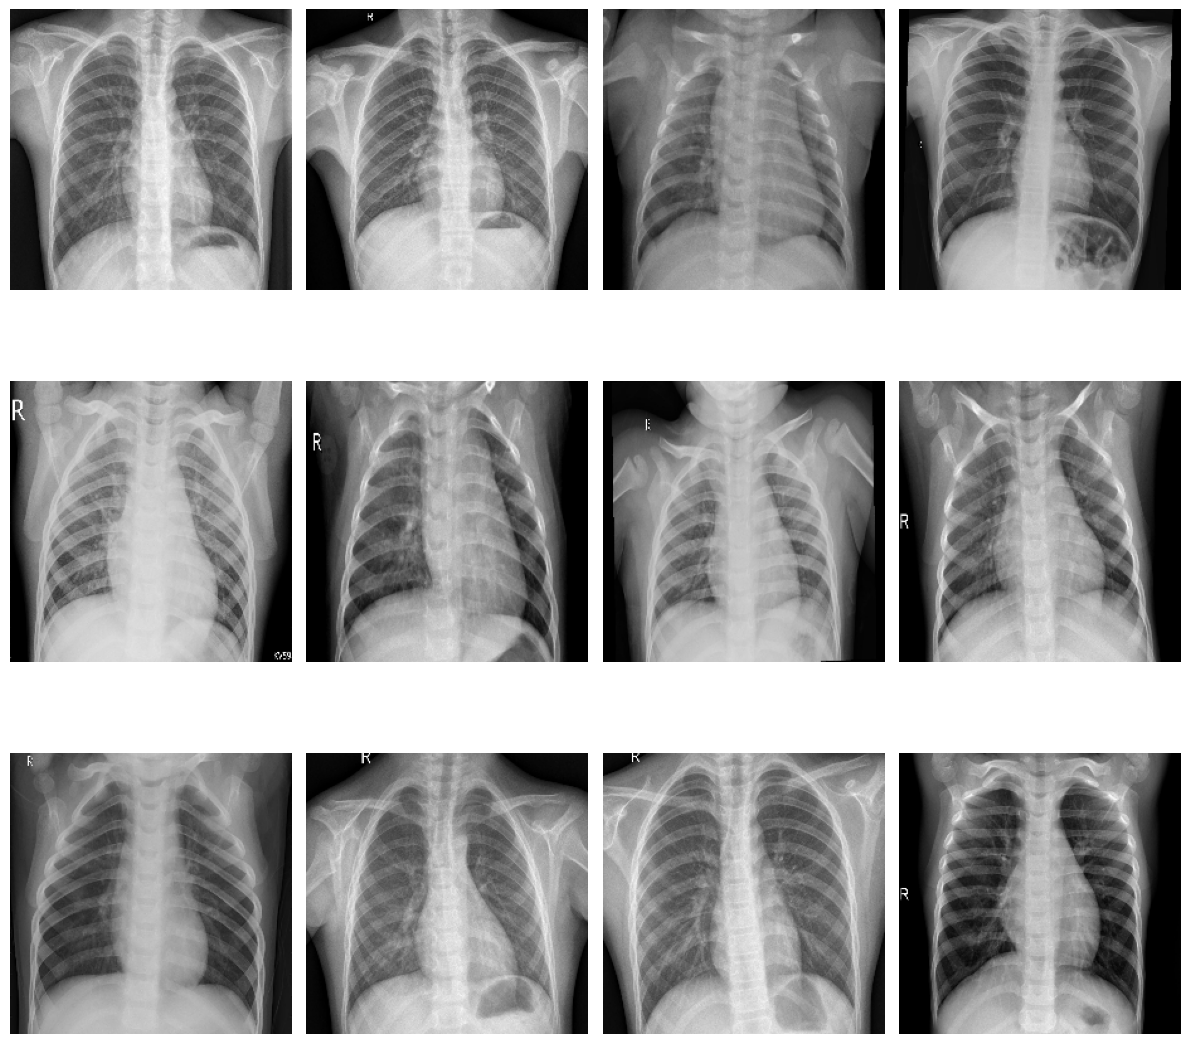

In [14]:
print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


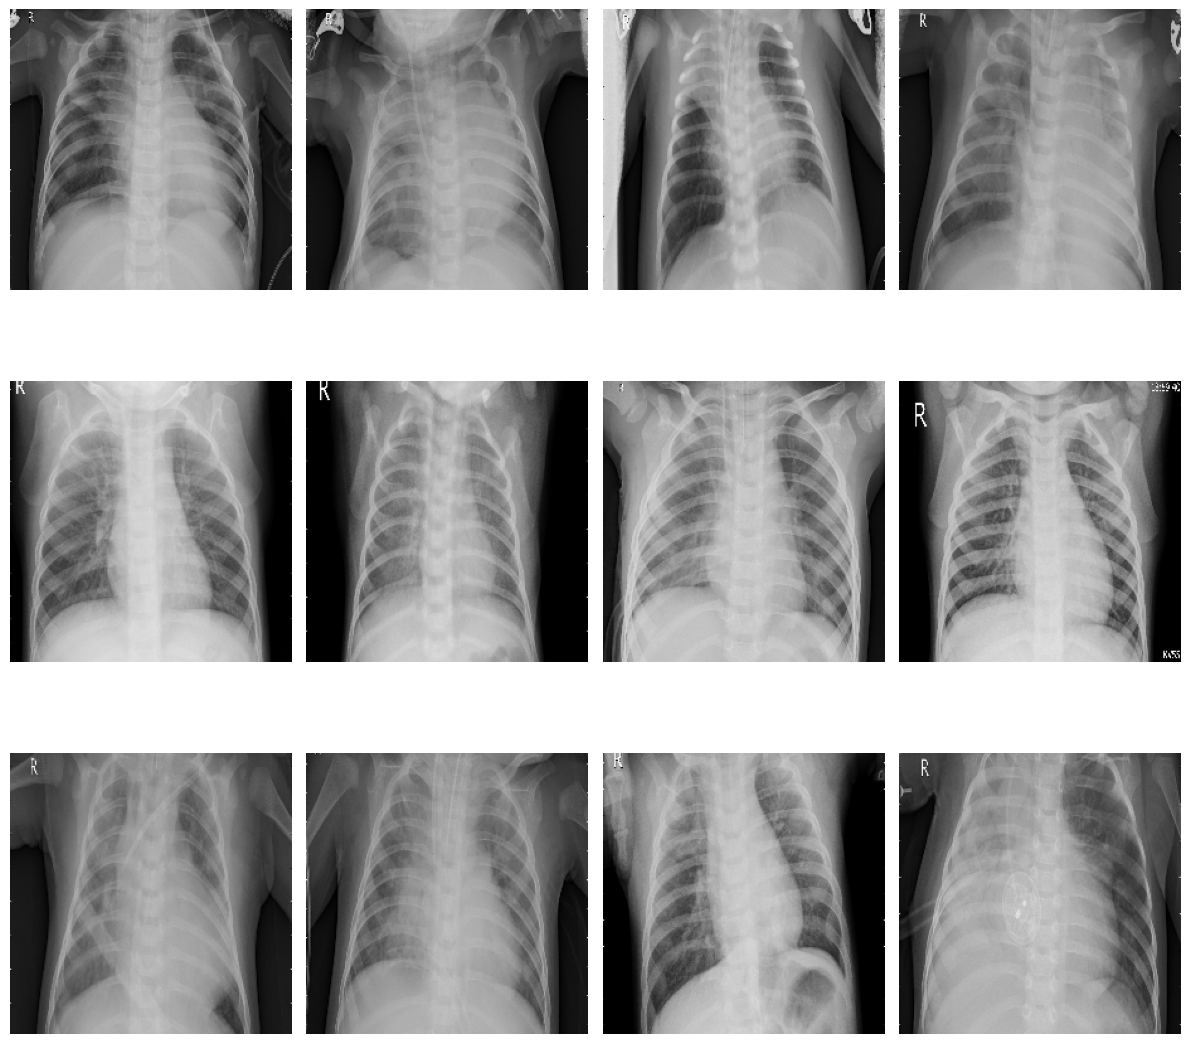

In [15]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

## Data Preparation

First, we need to create a validation set. To do that, we apply a simple stratified split on the original train dataset, using 80% for actual training and 20% for validation purposes.

In [66]:
df_train

class  \
0        Normal   
1        Normal   
2        Normal   
3        Normal   
4        Normal   
...         ...   
5227  Pneumonia   
5228  Pneumonia   
5229  Pneumonia   
5230  Pneumonia   
5231  Pneumonia   

                                                                image  
0           ../Data/chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg  
1           ../Data/chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg  
2                   ../Data/chest_xray/train/NORMAL/IM-0427-0001.jpeg  
3           ../Data/chest_xray/train/NORMAL/NORMAL2-IM-1260-0001.jpeg  
4              ../Data/chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg  
...                                                               ...  
5227      ../Data/chest_xray/train/PNEUMONIA/person142_virus_288.jpeg  
5228  ../Data/chest_xray/train/PNEUMONIA/person364_bacteria_1659.jpeg  
5229    ../Data/chest_xray/train/PNEUMONIA/person1323_virus_2283.jpeg  
5230     ../Data/chest_xray/train/PNEUMONIA/person772_virus_1401.jpeg  
5231     ../Data/chest_xray/train/PNEUMONIA/person501_virus_1010.jpeg  

[5232 rows x 2 columns]

In [69]:
# Separate by class
class1 = df_train[df_train['class'] == 'Normal']
class2 = df_train[df_train['class'] == 'Pneumonia']

# Pick equal numbers from each class for validation (based on smaller class size)
val_size = min(len(class1), len(class2)) // 2   # or set manually
val_class1 = class1.sample(val_size, random_state=SEED)
val_class2 = class2.sample(val_size, random_state=SEED)

# Combine into validation set
val_df = pd.concat([val_class1, val_class2])

# Remaining samples go to training
train_df = df_train.drop(val_df.index)

print("Class distribution in Training:")
print(train_df['class'].value_counts(normalize=True))
print()
print("Class distribution in Validation:")
print(val_df['class'].value_counts(normalize=True))


Class distribution in Training:
class
Pneumonia    0.82621
Normal       0.17379
Name: proportion, dtype: float64

Class distribution in Validation:
class
Normal       0.5
Pneumonia    0.5
Name: proportion, dtype: float64


In [70]:
train_df

class  \
0        Normal   
1        Normal   
4        Normal   
7        Normal   
8        Normal   
...         ...   
5225  Pneumonia   
5227  Pneumonia   
5228  Pneumonia   
5230  Pneumonia   
5231  Pneumonia   

                                                                image  
0           ../Data/chest_xray/train/NORMAL/NORMAL2-IM-0927-0001.jpeg  
1           ../Data/chest_xray/train/NORMAL/NORMAL2-IM-1056-0001.jpeg  
4              ../Data/chest_xray/train/NORMAL/IM-0656-0001-0001.jpeg  
7                   ../Data/chest_xray/train/NORMAL/IM-0757-0001.jpeg  
8           ../Data/chest_xray/train/NORMAL/NORMAL2-IM-1326-0001.jpeg  
...                                                               ...  
5225    ../Data/chest_xray/train/PNEUMONIA/person66_bacteria_325.jpeg  
5227      ../Data/chest_xray/train/PNEUMONIA/person142_virus_288.jpeg  
5228  ../Data/chest_xray/train/PNEUMONIA/person364_bacteria_1659.jpeg  
5230     ../Data/chest_xray/train/PNEUMONIA/person772_virus_1401.jpeg  
5231     ../Data/chest_xray/train/PNEUMONIA/person501_virus_1010.jpeg  

[3884 rows x 2 columns]

In [71]:
Counter(train_df['class'])

Counter({'Pneumonia': 3209, 'Normal': 675})

In [72]:
val_df

class  \
289      Normal   
1036     Normal   
535      Normal   
346      Normal   
1075     Normal   
...         ...   
4315  Pneumonia   
2211  Pneumonia   
4492  Pneumonia   
3253  Pneumonia   
1410  Pneumonia   

                                                                 image  
289     ../Data/chest_xray/train/NORMAL/NORMAL2-IM-0832-0001-0002.jpeg  
1036         ../Data/chest_xray/train/NORMAL/NORMAL2-IM-0522-0001.jpeg  
535          ../Data/chest_xray/train/NORMAL/NORMAL2-IM-0853-0001.jpeg  
346          ../Data/chest_xray/train/NORMAL/NORMAL2-IM-0981-0001.jpeg  
1075         ../Data/chest_xray/train/NORMAL/NORMAL2-IM-1277-0001.jpeg  
...                                                                ...  
4315  ../Data/chest_xray/train/PNEUMONIA/person1179_bacteria_3127.jpeg  
2211   ../Data/chest_xray/train/PNEUMONIA/person719_bacteria_2621.jpeg  
4492   ../Data/chest_xray/train/PNEUMONIA/person683_bacteria_2578.jpeg  
3253  ../Data/chest_xray/train/PNEUMONIA/person1636_bacteria_4338.jpeg  
1410  ../Data/chest_xray/train/PNEUMONIA/person1062_bacteria_2996.jpeg  

[1348 rows x 2 columns]

In [73]:
Counter(val_df['class'])

Counter({'Normal': 674, 'Pneumonia': 674})

In [74]:
Counter(df_test['class'])

Counter({'Pneumonia': 390, 'Normal': 234})

In [75]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False)  # randomly flip images


val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'image',
    y_col = 'class',
    target_size = (IMG_SIZE, IMG_SIZE),
    class_mode = 'binary',
    batch_size = BATCH,
    seed = SEED
)

ds_val = val_datagen.flow_from_dataframe(
    val_df,
    x_col = 'image',
    y_col = 'class',
    target_size = (IMG_SIZE, IMG_SIZE),
    class_mode = 'binary',
    batch_size = BATCH,
    seed = SEED
)

ds_test = val_datagen.flow_from_dataframe(
    df_test,
    x_col = 'image',
    y_col = 'class',
    target_size = (IMG_SIZE, IMG_SIZE),
    class_mode = 'binary',
    batch_size = 1,
    shuffle = False
)

Found 3884 validated image filenames belonging to 2 classes.
Found 1348 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


## Model

In [80]:
#Setting callbakcs
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)


checkpoint_cb = callbacks.ModelCheckpoint(
    "xray_model.h5",
    save_best_only=True
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 5,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [92]:
# Custom CNN
def CNNModel():
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [93]:
keras.backend.clear_session()

model = CNNModel()
model.compile(
    loss='binary_crossentropy', 
    optimizer = keras.optimizers.Adam(learning_rate=1e-5), 
    metrics=[
        'binary_accuracy',
    ])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,560,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,089 (10.00 MB)

 Trainable params: 2,620,865 (10.00 MB)

 Non-trainable params: 224 (896.00 B)

In [94]:
epoch = 30

history = model.fit(
    ds_train,
    batch_size = BATCH, epochs = epoch,
    validation_data=ds_val,
    callbacks=[checkpoint_cb],
    steps_per_epoch=(len(train_df)//BATCH),
    validation_steps=(len(val_df)//BATCH)
)

Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 43s 342ms/step - binary_accuracy: 0.7173 - loss: 1.3270 - val_binary_accuracy: 0.4993 - val_loss: 1.1312
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - binary_accuracy: 0.6875 - loss: 1.5286 - val_binary_accuracy: 0.5007 - val_loss: 1.1403
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - binary_accuracy: 0.7400 - loss: 1.2232 - val_binary_accuracy: 0.5015 - val_loss: 2.0678
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - binary_accuracy: 0.6250 - loss: 1.3407 - val_binary_accuracy: 0.5015 - val_loss: 2.1013
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 333ms/step - binary_accuracy: 0.7702 - loss: 1.2087 - val_binary_accuracy: 0.5000 - val_loss: 2.7930
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - binary_accuracy: 0.7188 - loss: 1.1368 - val_binary_accuracy: 0.5007 - val_loss: 2.8099
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 41s 340ms/step - binary_accuracy: 0.7937 - loss: 1.1036 - val_binary_accuracy: 0.5000 - val_loss

121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 334ms/step - binary_accuracy: 0.8282 - loss: 0.9823 - val_binary_accuracy: 0.7225 - val_loss: 0.7594
Epoch 14/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - binary_accuracy: 0.8125 - loss: 0.6716 - val_binary_accuracy: 0.7076 - val_loss: 0.8022
Epoch 15/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - binary_accuracy: 0.8384 - loss: 0.9487

121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 331ms/step - binary_accuracy: 0.8384 - loss: 0.9484 - val_binary_accuracy: 0.7991 - val_loss: 0.5577
Epoch 16/30
  1/121 ━━━━━━━━━━━━━━━━━━━━ 35s 295ms/step - binary_accuracy: 0.8438 - loss: 1.1030

121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - binary_accuracy: 0.8438 - loss: 1.1030 - val_binary_accuracy: 0.8036 - val_loss: 0.5548
Epoch 17/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 333ms/step - binary_accuracy: 0.8382 - loss: 0.9369 - val_binary_accuracy: 0.7917 - val_loss: 0.6209
Epoch 18/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - binary_accuracy: 0.8750 - loss: 0.5270 - val_binary_accuracy: 0.7924 - val_loss: 0.6147
Epoch 19/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - binary_accuracy: 0.8462 - loss: 0.9651

121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 329ms/step - binary_accuracy: 0.8462 - loss: 0.9651 - val_binary_accuracy: 0.8378 - val_loss: 0.5024
Epoch 20/30
  1/121 ━━━━━━━━━━━━━━━━━━━━ 34s 285ms/step - binary_accuracy: 0.9062 - loss: 0.5138

121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - binary_accuracy: 0.9062 - loss: 0.5138 - val_binary_accuracy: 0.8460 - val_loss: 0.4784
Epoch 21/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 329ms/step - binary_accuracy: 0.8429 - loss: 1.0802 - val_binary_accuracy: 0.8318 - val_loss: 0.5476
Epoch 22/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - binary_accuracy: 0.9688 - loss: 0.0644 - val_binary_accuracy: 0.8266 - val_loss: 0.5725
Epoch 23/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - binary_accuracy: 0.8385 - loss: 1.1167

121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 332ms/step - binary_accuracy: 0.8386 - loss: 1.1158 - val_binary_accuracy: 0.8862 - val_loss: 0.3832
Epoch 24/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - binary_accuracy: 0.9062 - loss: 0.2684 - val_binary_accuracy: 0.8802 - val_loss: 0.3967
Epoch 25/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 328ms/step - binary_accuracy: 0.8535 - loss: 0.9583 - val_binary_accuracy: 0.8728 - val_loss: 0.4302
Epoch 26/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - binary_accuracy: 0.7812 - loss: 1.1075 - val_binary_accuracy: 0.8720 - val_loss: 0.4279
Epoch 27/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - binary_accuracy: 0.8513 - loss: 1.0832

121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 330ms/step - binary_accuracy: 0.8513 - loss: 1.0831 - val_binary_accuracy: 0.9226 - val_loss: 0.3304
Epoch 28/30
  1/121 ━━━━━━━━━━━━━━━━━━━━ 35s 298ms/step - binary_accuracy: 0.8750 - loss: 0.5485

121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - binary_accuracy: 0.8750 - loss: 0.5485 - val_binary_accuracy: 0.9234 - val_loss: 0.3296
Epoch 29/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - binary_accuracy: 0.8659 - loss: 0.8973

121/121 ━━━━━━━━━━━━━━━━━━━━ 40s 329ms/step - binary_accuracy: 0.8659 - loss: 0.8978 - val_binary_accuracy: 0.9226 - val_loss: 0.3292
Epoch 30/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - binary_accuracy: 0.7812 - loss: 0.9056 - val_binary_accuracy: 0.9234 - val_loss: 0.3303


In [95]:
def plot_loss_acc(history, model_name):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = history.epoch

    plt.figure(figsize=(7, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.suptitle(f'Model Training Performance: {model_name}', fontsize=14)
    plt.show()


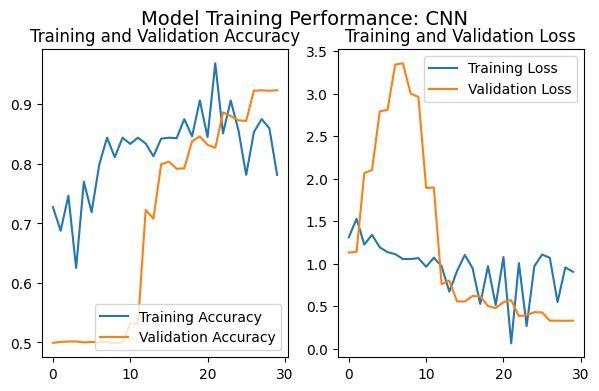

In [96]:
plot_loss_acc(history, "CNN")

In [97]:
score = model.evaluate(ds_val, steps = len(val_df)//BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.3251897096633911
Val accuracy: 0.9233630895614624


In [98]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8861863613128662
Test accuracy: 0.8028846383094788


### Performance Metrics

In [131]:
def evaluate_model(model, model_name):
    print(f'Model: {model_name}')

    # Predictions
    y_pred_proba = model.predict(ds_test, steps=len(df_test), verbose=1)
    y_pred = (y_pred_proba > 0.5).astype("int32").ravel()
    y_true = ds_test.classes

    # Confusion Matrix + Metrics
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP+TN) / (TP+TN+FN+FP)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    f1_score = 2*precision*sensitivity / (precision + sensitivity)

    print(f'Accuracy: {accuracy:.4f}')
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # ROC values
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Side-by-side plots
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", ax=axes[0], colorbar=False)
    axes[0].set_title("Confusion Matrix")

    # ROC curve
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title("ROC Curve")
    axes[1].legend(loc="lower right")

    plt.suptitle(f"Evaluation Results: {model_name}", fontsize=14)
    plt.tight_layout()
    plt.show()


Model: CNN
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Accuracy: 0.8029
Precision: 0.7811
Sensitivity (Recall): 0.9513
Specificity: 0.5556
F1 Score: 0.8578


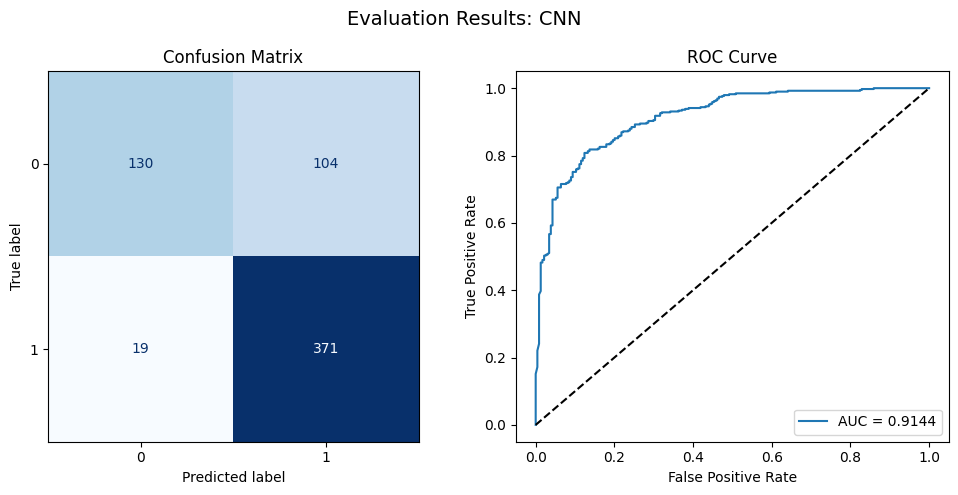

In [132]:
# Performance Metrics
evaluate_model(model, 'CNN')

## Transfer Learning

### ResNet

In [100]:
# ResNet152V2 model
base_model_resnet = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model_resnet.trainable = False

def ResNetModel():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model_resnet(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [101]:
keras.backend.clear_session()

model_resnet = ResNetModel()
model_resnet.compile(
    loss='binary_crossentropy', 
    optimizer = keras.optimizers.Adam(learning_rate=1e-5), 
    metrics=['binary_accuracy']
)

model_resnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [102]:
checkpoint_resnet = callbacks.ModelCheckpoint(
    "xray_resnet_model.h5",
    save_best_only=True
)

In [104]:
resnet_epoch = 15

history_resnet = model_resnet.fit(
    ds_train,
    batch_size = BATCH, epochs = resnet_epoch,
    validation_data=ds_val,
    callbacks=[checkpoint_resnet, early_stopping],
    steps_per_epoch=(len(train_df)//BATCH),
    validation_steps=(len(val_df)//BATCH)
)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - binary_accuracy: 0.7718 - loss: 0.5440

121/121 ━━━━━━━━━━━━━━━━━━━━ 90s 744ms/step - binary_accuracy: 0.7720 - loss: 0.5437 - val_binary_accuracy: 0.6183 - val_loss: 0.6832
Epoch 2/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1:13 609ms/step - binary_accuracy: 0.8750 - loss: 0.3647

121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - binary_accuracy: 0.8750 - loss: 0.3647 - val_binary_accuracy: 0.6183 - val_loss: 0.6815
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - binary_accuracy: 0.8273 - loss: 0.4036

121/121 ━━━━━━━━━━━━━━━━━━━━ 83s 687ms/step - binary_accuracy: 0.8274 - loss: 0.4035 - val_binary_accuracy: 0.7671 - val_loss: 0.4560
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - binary_accuracy: 0.9062 - loss: 0.2225 - val_binary_accuracy: 0.7671 - val_loss: 0.4560
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - binary_accuracy: 0.8502 - loss: 0.3232

121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 679ms/step - binary_accuracy: 0.8503 - loss: 0.3231 - val_binary_accuracy: 0.8222 - val_loss: 0.3780
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - binary_accuracy: 0.7812 - loss: 0.3450 - val_binary_accuracy: 0.8207 - val_loss: 0.3783
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - binary_accuracy: 0.8809 - loss: 0.2798

121/121 ━━━━━━━━━━━━━━━━━━━━ 84s 697ms/step - binary_accuracy: 0.8809 - loss: 0.2798 - val_binary_accuracy: 0.8676 - val_loss: 0.3172
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - binary_accuracy: 0.8125 - loss: 0.3968 - val_binary_accuracy: 0.8668 - val_loss: 0.3178
Epoch 9/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - binary_accuracy: 0.9065 - loss: 0.2448

121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 680ms/step - binary_accuracy: 0.9065 - loss: 0.2448 - val_binary_accuracy: 0.8884 - val_loss: 0.2777
Epoch 10/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - binary_accuracy: 0.7812 - loss: 0.3717 - val_binary_accuracy: 0.8884 - val_loss: 0.2793
Epoch 11/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - binary_accuracy: 0.9037 - loss: 0.2320

121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 674ms/step - binary_accuracy: 0.9037 - loss: 0.2319 - val_binary_accuracy: 0.8958 - val_loss: 0.2628
Epoch 12/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1:02 523ms/step - binary_accuracy: 0.8750 - loss: 0.2598

121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - binary_accuracy: 0.8750 - loss: 0.2598 - val_binary_accuracy: 0.8966 - val_loss: 0.2610
Epoch 13/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - binary_accuracy: 0.9182 - loss: 0.2001

121/121 ━━━━━━━━━━━━━━━━━━━━ 81s 672ms/step - binary_accuracy: 0.9182 - loss: 0.2001 - val_binary_accuracy: 0.9070 - val_loss: 0.2378
Epoch 14/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - binary_accuracy: 0.9375 - loss: 0.1994 - val_binary_accuracy: 0.9070 - val_loss: 0.2381
Epoch 15/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - binary_accuracy: 0.9150 - loss: 0.1989

121/121 ━━━━━━━━━━━━━━━━━━━━ 82s 680ms/step - binary_accuracy: 0.9150 - loss: 0.1990 - val_binary_accuracy: 0.9107 - val_loss: 0.2262


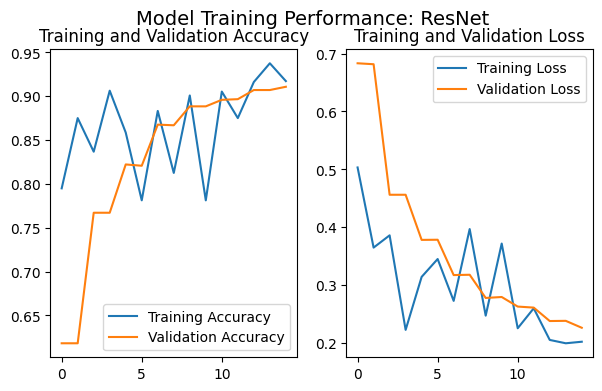

In [105]:
plot_loss_acc(history_resnet, 'ResNet')

In [106]:
score = model_resnet.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5046661496162415
Test accuracy: 0.7836538553237915


#### Performance Metrics

Model: ResNet
624/624 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step
Accuracy: 0.7837
Precision: 0.7576
Sensitivity (Recall): 0.9615
Specificity: 0.4872
F1 Score: 0.8475


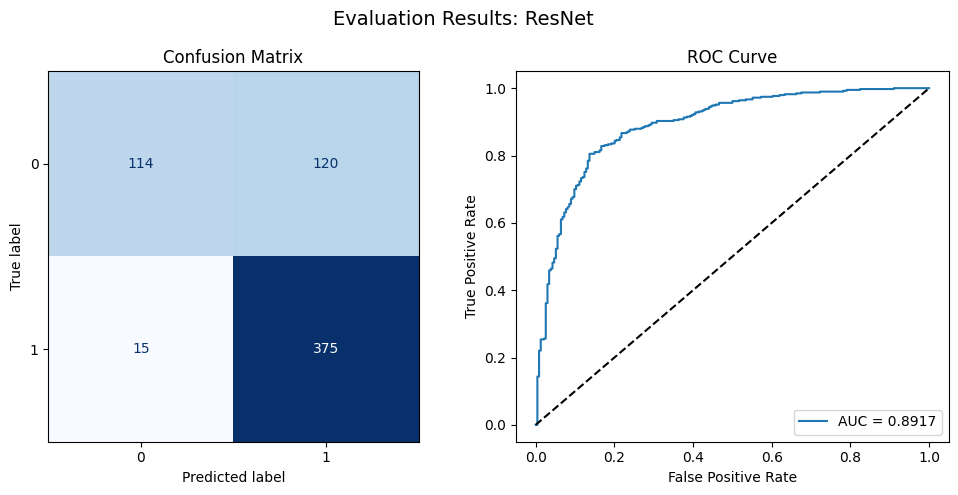

In [133]:
# Performance Metrics
evaluate_model(model_resnet, 'ResNet')

### Fine Tuning the ResNet Model

In [110]:
base_model_resnet_v2 = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model_resnet_v2.trainable = True

# Freeze all layers except for the
for layer in base_model_resnet_v2.layers[:-13]:
    layer.trainable = False

def ResNetModelV2():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model_resnet_v2(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

model_resnet_v2 = ResNetModelV2()
model_resnet_v2.compile(
    loss='binary_crossentropy', 
    optimizer = keras.optimizers.Adam(learning_rate=1e-5), 
    metrics=['binary_accuracy']
)

model_resnet_v2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 4,731,137 (18.05 MB)

 Non-trainable params: 53,862,912 (205.47 MB)

In [111]:
checkpoint_resnet_v2 = callbacks.ModelCheckpoint(
    "xray_resnet_v2_model.h5",
    save_best_only=True
)

In [113]:
resnet_epoch = 15

history_resnet_v2 = model_resnet_v2.fit(
    ds_train,
    batch_size = BATCH, epochs = resnet_epoch,
    validation_data=ds_val,
    callbacks=[checkpoint_resnet_v2],
    steps_per_epoch=(len(train_df)//BATCH),
    validation_steps=(len(val_df)//BATCH)
)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - binary_accuracy: 0.7742 - loss: 0.5064

121/121 ━━━━━━━━━━━━━━━━━━━━ 93s 772ms/step - binary_accuracy: 0.7746 - loss: 0.5056 - val_binary_accuracy: 0.8705 - val_loss: 0.3626
Epoch 2/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1:08 572ms/step - binary_accuracy: 1.0000 - loss: 0.2121

121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - binary_accuracy: 1.0000 - loss: 0.2121 - val_binary_accuracy: 0.8720 - val_loss: 0.3592
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - binary_accuracy: 0.9045 - loss: 0.2558

121/121 ━━━━━━━━━━━━━━━━━━━━ 84s 696ms/step - binary_accuracy: 0.9045 - loss: 0.2557 - val_binary_accuracy: 0.9263 - val_loss: 0.2390
Epoch 4/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1:10 589ms/step - binary_accuracy: 0.9062 - loss: 0.2135

121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - binary_accuracy: 0.9062 - loss: 0.2135 - val_binary_accuracy: 0.9263 - val_loss: 0.2388
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - binary_accuracy: 0.9226 - loss: 0.1914

121/121 ━━━━━━━━━━━━━━━━━━━━ 84s 699ms/step - binary_accuracy: 0.9227 - loss: 0.1913 - val_binary_accuracy: 0.9345 - val_loss: 0.1907
Epoch 6/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1:09 580ms/step - binary_accuracy: 0.9688 - loss: 0.1148

121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - binary_accuracy: 0.9688 - loss: 0.1148 - val_binary_accuracy: 0.9353 - val_loss: 0.1899
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - binary_accuracy: 0.9410 - loss: 0.1587

121/121 ━━━━━━━━━━━━━━━━━━━━ 85s 701ms/step - binary_accuracy: 0.9410 - loss: 0.1587 - val_binary_accuracy: 0.9449 - val_loss: 0.1555
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - binary_accuracy: 0.9375 - loss: 0.1642 - val_binary_accuracy: 0.9449 - val_loss: 0.1566
Epoch 9/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - binary_accuracy: 0.9466 - loss: 0.1411

121/121 ━━━━━━━━━━━━━━━━━━━━ 85s 702ms/step - binary_accuracy: 0.9465 - loss: 0.1412 - val_binary_accuracy: 0.9464 - val_loss: 0.1468
Epoch 10/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - binary_accuracy: 1.0000 - loss: 0.0772 - val_binary_accuracy: 0.9457 - val_loss: 0.1469
Epoch 11/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - binary_accuracy: 0.9508 - loss: 0.1381

121/121 ━━━━━━━━━━━━━━━━━━━━ 86s 709ms/step - binary_accuracy: 0.9508 - loss: 0.1380 - val_binary_accuracy: 0.9472 - val_loss: 0.1424
Epoch 12/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 1:08 575ms/step - binary_accuracy: 1.0000 - loss: 0.0725

121/121 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - binary_accuracy: 1.0000 - loss: 0.0725 - val_binary_accuracy: 0.9464 - val_loss: 0.1419
Epoch 13/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - binary_accuracy: 0.9462 - loss: 0.1307

121/121 ━━━━━━━━━━━━━━━━━━━━ 85s 702ms/step - binary_accuracy: 0.9462 - loss: 0.1307 - val_binary_accuracy: 0.9546 - val_loss: 0.1368
Epoch 14/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - binary_accuracy: 0.9688 - loss: 0.1086 - val_binary_accuracy: 0.9546 - val_loss: 0.1377
Epoch 15/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - binary_accuracy: 0.9529 - loss: 0.1303

121/121 ━━━━━━━━━━━━━━━━━━━━ 85s 703ms/step - binary_accuracy: 0.9529 - loss: 0.1302 - val_binary_accuracy: 0.9539 - val_loss: 0.1293


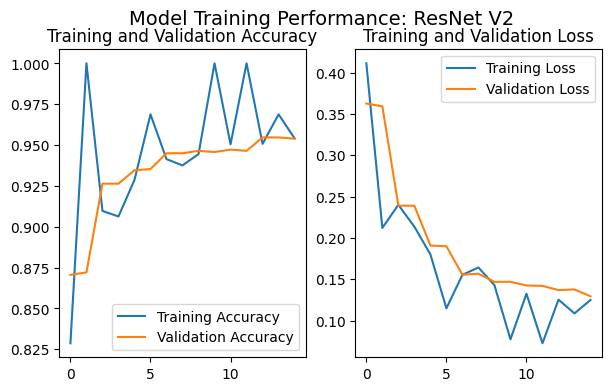

In [115]:
plot_loss_acc(history_resnet_v2, 'ResNet V2')

In [116]:
score = model_resnet_v2.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4171968698501587
Test accuracy: 0.8525640964508057


Model: ResNet V2
624/624 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step
Accuracy: 0.8526
Precision: 0.8143
Sensitivity (Recall): 0.9897
Specificity: 0.6239
F1 Score: 0.8935


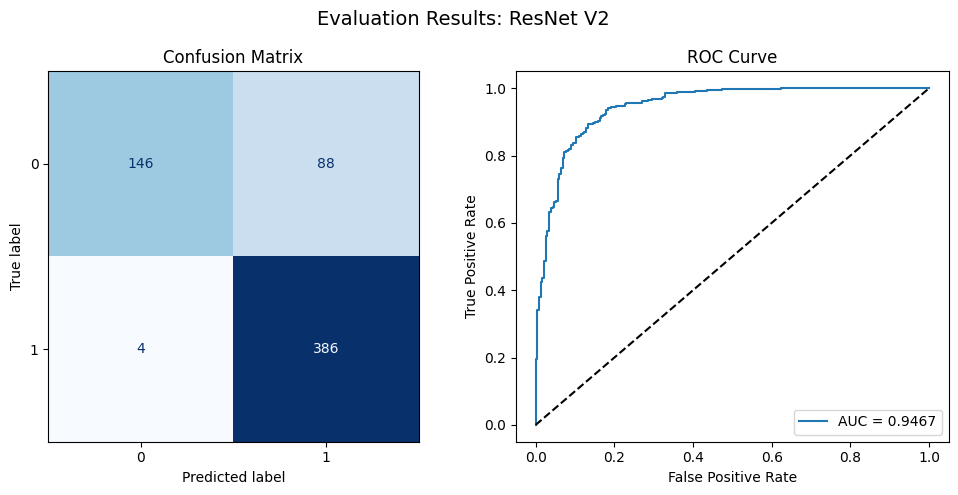

In [134]:
evaluate_model(model_resnet_v2, 'ResNet V2')

## VGG Model

In [126]:
# VGG16 model
base_model_vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model_vgg.trainable = True

# Freeze all layers except last 5
for layer in base_model_vgg.layers[:-5]:
    layer.trainable = False

def VGGModel():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model_vgg(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [127]:
keras.backend.clear_session()

model_vgg = VGGModel()
model_vgg.compile(
    loss='binary_crossentropy', 
    optimizer = keras.optimizers.Adam(learning_rate=1e-5), 
    metrics=['binary_accuracy']
)

model_vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 7,145,217 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [128]:
checkpoint_vgg = callbacks.ModelCheckpoint(
    "xray_vgg_model.h5",
    save_best_only=True
)

In [129]:
vgg_epoch = 15

history_vgg = model_vgg.fit(
    ds_train,
    batch_size = BATCH, epochs = vgg_epoch,
    validation_data=ds_val,
    callbacks=[checkpoint_vgg, early_stopping],
    steps_per_epoch=(len(train_df)//BATCH),
    validation_steps=(len(val_df)//BATCH)
)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - binary_accuracy: 0.8136 - loss: 0.4388

121/121 ━━━━━━━━━━━━━━━━━━━━ 69s 562ms/step - binary_accuracy: 0.8140 - loss: 0.4379 - val_binary_accuracy: 0.9182 - val_loss: 0.2295
Epoch 2/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 53s 445ms/step - binary_accuracy: 0.9375 - loss: 0.1686

121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - binary_accuracy: 0.9375 - loss: 0.1686 - val_binary_accuracy: 0.9211 - val_loss: 0.2241
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - binary_accuracy: 0.9216 - loss: 0.1864

121/121 ━━━━━━━━━━━━━━━━━━━━ 65s 539ms/step - binary_accuracy: 0.9217 - loss: 0.1863 - val_binary_accuracy: 0.9442 - val_loss: 0.1626
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - binary_accuracy: 0.9688 - loss: 0.0629 - val_binary_accuracy: 0.9449 - val_loss: 0.1634
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - binary_accuracy: 0.9324 - loss: 0.1539

121/121 ━━━━━━━━━━━━━━━━━━━━ 65s 535ms/step - binary_accuracy: 0.9324 - loss: 0.1539 - val_binary_accuracy: 0.9457 - val_loss: 0.1450
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - binary_accuracy: 0.9688 - loss: 0.1061 - val_binary_accuracy: 0.9457 - val_loss: 0.1465
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - binary_accuracy: 0.9572 - loss: 0.1222

121/121 ━━━━━━━━━━━━━━━━━━━━ 66s 544ms/step - binary_accuracy: 0.9572 - loss: 0.1221 - val_binary_accuracy: 0.9516 - val_loss: 0.1210
Epoch 8/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 49s 413ms/step - binary_accuracy: 1.0000 - loss: 0.0257

121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - binary_accuracy: 1.0000 - loss: 0.0257 - val_binary_accuracy: 0.9546 - val_loss: 0.1197
Epoch 9/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 65s 535ms/step - binary_accuracy: 0.9527 - loss: 0.1101 - val_binary_accuracy: 0.9368 - val_loss: 0.1534
Epoch 10/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - binary_accuracy: 1.0000 - loss: 0.0071 - val_binary_accuracy: 0.9405 - val_loss: 0.1412
Epoch 11/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 64s 534ms/step - binary_accuracy: 0.9627 - loss: 0.1090 - val_binary_accuracy: 0.9427 - val_loss: 0.1355
Epoch 12/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - binary_accuracy: 0.8750 - loss: 0.2185 - val_binary_accuracy: 0.9382 - val_loss: 0.1484
Epoch 13/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - binary_accuracy: 0.9669 - loss: 0.0961

121/121 ━━━━━━━━━━━━━━━━━━━━ 66s 544ms/step - binary_accuracy: 0.9669 - loss: 0.0961 - val_binary_accuracy: 0.9561 - val_loss: 0.1084
Epoch 14/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 51s 433ms/step - binary_accuracy: 1.0000 - loss: 0.0310

121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - binary_accuracy: 1.0000 - loss: 0.0310 - val_binary_accuracy: 0.9613 - val_loss: 0.1064
Epoch 15/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 65s 534ms/step - binary_accuracy: 0.9575 - loss: 0.1036 - val_binary_accuracy: 0.9606 - val_loss: 0.1132


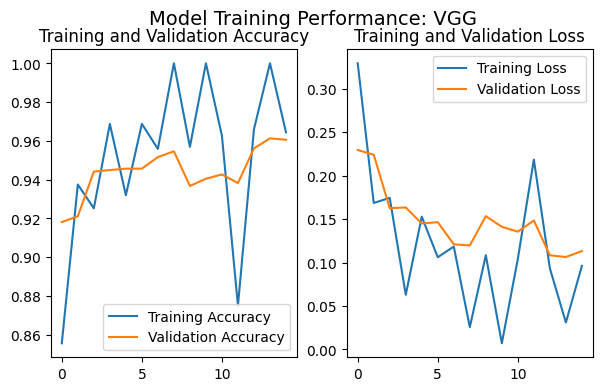

In [135]:
plot_loss_acc(history_vgg, 'VGG')

In [136]:
score = model_vgg.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3317345082759857
Test accuracy: 0.8878205418586731


### Performance Metrics

Model: VGG
624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
Accuracy: 0.8878
Precision: 0.8540
Sensitivity (Recall): 0.9897
Specificity: 0.7179
F1 Score: 0.9169


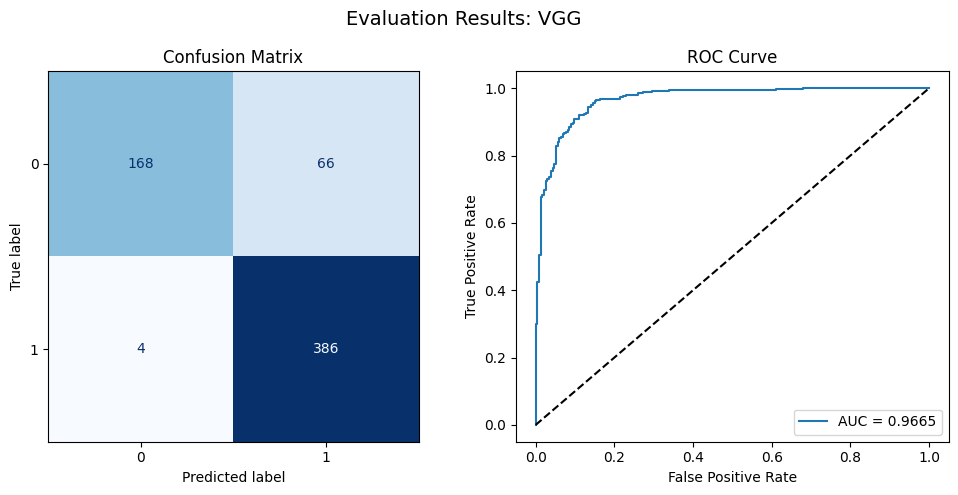

In [137]:
evaluate_model(model_vgg, 'VGG')

## Testing


In [179]:
# VGG16 model
base_model_vgg_testing = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model_vgg_testing.trainable = True

# Freeze all layers except last 5
for layer in base_model_vgg_testing.layers[:-5]:
    layer.trainable = False

def VGGModel_testing():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model_vgg_testing.output

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=base_model_vgg_testing.input, outputs=output)
    
    return model

In [180]:
keras.backend.clear_session()

model_vgg_testing = VGGModel_testing()
model_vgg_testing.compile(
    loss='binary_crossentropy', 
    optimizer = keras.optimizers.Adam(learning_rate=1e-5), 
    metrics=['binary_accuracy']
)

model_vgg_testing.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 7,145,217 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [181]:
checkpoint_vgg_testing = callbacks.ModelCheckpoint(
    "xray_vgg_model_testing.h5",
    save_best_only=True
)

In [183]:
vgg_epoch = 15

history_vgg_testing = model_vgg_testing.fit(
    ds_train,
    batch_size = BATCH, epochs = vgg_epoch,
    validation_data=ds_val,
    callbacks=[checkpoint_vgg_testing, early_stopping],
    steps_per_epoch=(len(train_df)//BATCH),
    validation_steps=(len(val_df)//BATCH)
)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - binary_accuracy: 0.7878 - loss: 0.4629

121/121 ━━━━━━━━━━━━━━━━━━━━ 68s 551ms/step - binary_accuracy: 0.7883 - loss: 0.4619 - val_binary_accuracy: 0.9159 - val_loss: 0.2608
Epoch 2/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - binary_accuracy: 0.8438 - loss: 0.2318

121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - binary_accuracy: 0.8438 - loss: 0.2318 - val_binary_accuracy: 0.9107 - val_loss: 0.2572
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - binary_accuracy: 0.9174 - loss: 0.1960

121/121 ━━━━━━━━━━━━━━━━━━━━ 65s 540ms/step - binary_accuracy: 0.9175 - loss: 0.1959 - val_binary_accuracy: 0.9256 - val_loss: 0.2214
Epoch 4/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 49s 410ms/step - binary_accuracy: 1.0000 - loss: 0.0758

121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - binary_accuracy: 1.0000 - loss: 0.0758 - val_binary_accuracy: 0.9315 - val_loss: 0.2046
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - binary_accuracy: 0.9435 - loss: 0.1560

121/121 ━━━━━━━━━━━━━━━━━━━━ 66s 545ms/step - binary_accuracy: 0.9435 - loss: 0.1559 - val_binary_accuracy: 0.9464 - val_loss: 0.1485
Epoch 6/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 52s 440ms/step - binary_accuracy: 0.9062 - loss: 0.2025

121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - binary_accuracy: 0.9062 - loss: 0.2025 - val_binary_accuracy: 0.9464 - val_loss: 0.1475
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 65s 539ms/step - binary_accuracy: 0.9524 - loss: 0.1312 - val_binary_accuracy: 0.9182 - val_loss: 0.1914
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - binary_accuracy: 0.9375 - loss: 0.3721 - val_binary_accuracy: 0.9271 - val_loss: 0.1690
Epoch 9/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - binary_accuracy: 0.9594 - loss: 0.1117

121/121 ━━━━━━━━━━━━━━━━━━━━ 67s 556ms/step - binary_accuracy: 0.9595 - loss: 0.1117 - val_binary_accuracy: 0.9546 - val_loss: 0.1113
Epoch 10/15
  1/121 ━━━━━━━━━━━━━━━━━━━━ 54s 451ms/step - binary_accuracy: 0.9062 - loss: 0.1948

121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - binary_accuracy: 0.9062 - loss: 0.1948 - val_binary_accuracy: 0.9613 - val_loss: 0.1092
Epoch 11/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 67s 553ms/step - binary_accuracy: 0.9551 - loss: 0.1178 - val_binary_accuracy: 0.9531 - val_loss: 0.1163
Epoch 12/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - binary_accuracy: 0.9062 - loss: 0.1563 - val_binary_accuracy: 0.9546 - val_loss: 0.1125
Epoch 13/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 66s 548ms/step - binary_accuracy: 0.9641 - loss: 0.0964 - val_binary_accuracy: 0.9531 - val_loss: 0.1202
Epoch 14/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - binary_accuracy: 0.9688 - loss: 0.0745 - val_binary_accuracy: 0.9554 - val_loss: 0.1134
Epoch 15/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - binary_accuracy: 0.9657 - loss: 0.0867

121/121 ━━━━━━━━━━━━━━━━━━━━ 67s 557ms/step - binary_accuracy: 0.9657 - loss: 0.0867 - val_binary_accuracy: 0.9568 - val_loss: 0.1053


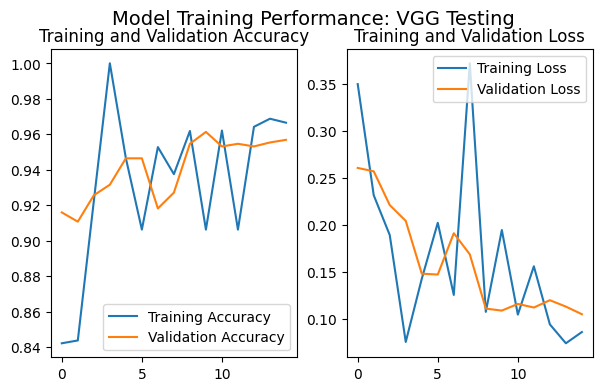

In [184]:
plot_loss_acc(history_vgg_testing, 'VGG Testing')

In [185]:
score = model_vgg_testing.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27783361077308655
Test accuracy: 0.9038461446762085


Model: VGG Testing
624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step
Accuracy: 0.9038
Precision: 0.8767
Sensitivity (Recall): 0.9846
Specificity: 0.7692
F1 Score: 0.9275


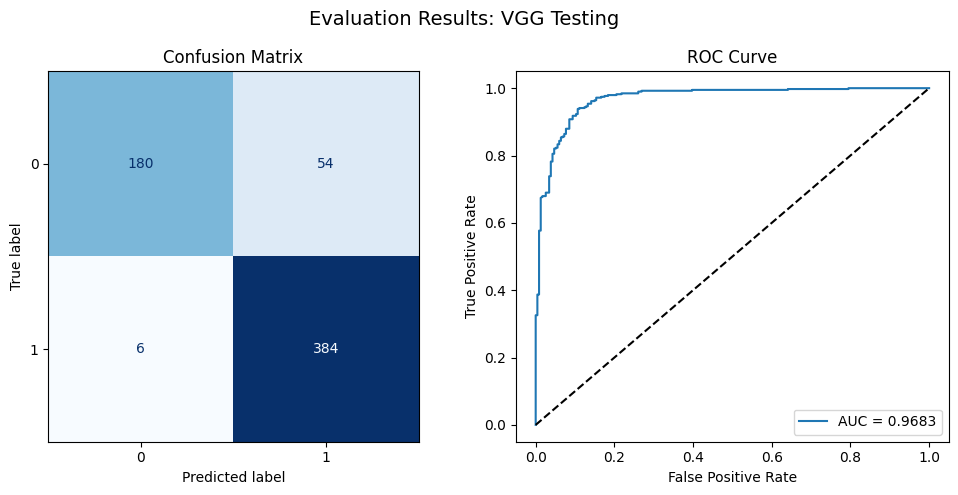

In [186]:
evaluate_model(model_vgg_testing, 'VGG Testing')

In [ ]:
# Checking all the wrongly predicted images

y_pred_proba = model_vgg_testing.predict(ds_test, steps=len(df_test), verbose=1) 
y_true = np.array(ds_test.classes) 

if hasattr(ds_test, "filepaths"):
    filepaths = np.array(ds_test.filepaths)
elif hasattr(ds_test, "filenames"):
    filepaths = np.array(ds_test.filenames)
else:
    filepaths = np.array(df_test['image'])

if y_pred_proba.ndim == 2 and y_pred_proba.shape[1] > 1:
    y_pred = np.argmax(y_pred_proba, axis=1)
    pred_score = y_pred_proba.max(axis=1)
else:
    y_pred_proba = y_pred_proba.ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)
    pred_score = y_pred_proba

results_df = pd.DataFrame({
    "filepath": filepaths,
    "y_true": y_true,
    "y_pred": y_pred,
    "pred_score": pred_score
})

wrong_df = results_df[results_df["y_true"] != results_df["y_pred"]].reset_index(drop=True)

print(f"Total samples: {len(results_df)}")
print(f"Wrongly predicted: {len(wrong_df)}")

624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
Total samples: 624
Wrongly predicted: 60


In [227]:
wrong_df.sort_values(['filepath'])

filepath  y_true  \
19               ../Data/chest_xray/test/NORMAL/IM-0022-0001.jpeg       0   
20               ../Data/chest_xray/test/NORMAL/IM-0036-0001.jpeg       0   
4                ../Data/chest_xray/test/NORMAL/IM-0073-0001.jpeg       0   
17       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0007-0001.jpeg       0   
27       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0028-0001.jpeg       0   
41       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0030-0001.jpeg       0   
26       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0052-0001.jpeg       0   
31       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0059-0001.jpeg       0   
38       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0066-0001.jpeg       0   
25       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0073-0001.jpeg       0   
13       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0081-0001.jpeg       0   
9        ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0086-0001.jpeg       0   
15       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0095-0001.jpeg       0   
29       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0096-0001.jpeg       0   
0        ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0102-0001.jpeg       0   
18       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0105-0001.jpeg       0   
42       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0107-0001.jpeg       0   
21       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0111-0001.jpeg       0   
37       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0120-0001.jpeg       0   
46       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0132-0001.jpeg       0   
50       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0145-0001.jpeg       0   
34       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0150-0001.jpeg       0   
32       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0171-0001.jpeg       0   
44  ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0173-0001-0001.jpeg       0   
3   ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0173-0001-0002.jpeg       0   
48       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0195-0001.jpeg       0   
6        ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0196-0001.jpeg       0   
53       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0198-0001.jpeg       0   
35       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0199-0001.jpeg       0   
33       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0201-0001.jpeg       0   
40       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0206-0001.jpeg       0   
16       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0210-0001.jpeg       0   
43       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0219-0001.jpeg       0   
52       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0221-0001.jpeg       0   
8        ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0222-0001.jpeg       0   
1        ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg       0   
28       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0232-0001.jpeg       0   
39       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0233-0001.jpeg       0   
22       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0237-0001.jpeg       0   
45       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0238-0001.jpeg       0   
7        ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0241-0001.jpeg       0   
51  ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0246-0001-0001.jpeg       0   
2   ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0246-0001-0002.jpeg       0   
11       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0246-0001.jpeg       0   
24       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0251-0001.jpeg       0   
12       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0252-0001.jpeg       0   
47       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0256-0001.jpeg       0   
23       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0259-0001.jpeg       0   
10       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0267-0001.jpeg       0   
36       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0316-0001.jpeg       0   
30       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-0330-0001.jpeg       0   
14       ../Data/chest_xray/test/NORMAL/NORMAL2-IM-03

In [286]:
def predict_single_image(img_path, model, img_size=224, class_names=['Normal', 'Pneumonia'], preprocess_fn=None):
    orig_bgr = cv2.imread(img_path)
    if orig_bgr is None:
        raise ValueError(f"Could not read image at {img_path}")
    orig_bgr = cv2.resize(orig_bgr, (img_size, img_size))
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

    # produce array for model input
    img_arr = orig_rgb.astype("float32")
    img_batch = np.expand_dims(img_arr, axis=0)  # (1,H,W,3)
    if preprocess_fn is not None:
        img_for_model = preprocess_fn(np.copy(img_batch))
    else:
        img_for_model = img_batch / 255.0

    # Predict
    preds = model.predict(img_for_model, verbose=0)
    if preds[0] > 0.5:
        pred_class_idx = 1
    else:
        pred_class_idx = 0

    if class_names:
        pred_class_name = class_names[pred_class_idx]
    else:
        pred_class_name = str(pred_class_idx)

    return {
        "prediction_probability": preds[0],
        "predicted_class": pred_class_name
    }

In [287]:
img_path = '../Data/chest_xray/test/NORMAL/IM-0005-0001.jpeg'
result = predict_single_image(img_path, model_vgg_testing, img_size=224)
print(result)

{'prediction_probability': array([0.02490874], dtype=float32), 'predicted_class': 'Normal'}


In [288]:
img_path = '../Data/chest_xray/test/PNEUMONIA/person3_virus_17.jpeg'
result = predict_single_image(img_path, model_vgg_testing, img_size=224)
print(result)

{'prediction_probability': array([0.6375263], dtype=float32), 'predicted_class': 'Pneumonia'}


## Explainability

| Model   | Accuracy | Precision | Recall | F1 Score | ROC-AUC |
|---------|----------|-----------|--------|----------|---------|
| CNN     | 0.8029   | 0.7811    | 0.9513 | 0.8578   | 0.9144  |
| ResNet  | 0.7837   | 0.7576    | 0.9615 | 0.8475   | 0.8917  |
| ResNetV2| 0.8526   | 0.8143    | 0.9897 | 0.8935   | 0.9467  |
| VGG     | 0.8878   | 0.8540    | 0.9897 | 0.9169   | 0.9665  |
| VGG Test| 0.9038   | 0.8767    | 0.9846 | 0.9275   | 0.9683  |

From the above table, we can infer that VGG Test model performed the best out of all the model. Moving forward, we will take VGG as the main model.


In [208]:
img_path_pneumonia = '../Data/chest_xray/test/PNEUMONIA/person1_virus_13.jpeg'
img_path_normal = '../Data/chest_xray/test/NORMAL/IM-0006-0001.jpeg'

In [209]:
model_vgg_testing.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,070,917 (110.90 MB)

 Trainable params: 7,145,217 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,290,436 (54.51 MB)

In [210]:
pretrained_model = model_vgg_testing

In [293]:
def grad_cam_evaluateV2(
    img_path,
    model,
    classifier_layer_names=['global_average_pooling2d', 'dense', 'dropout', 'dense_1'],
    classifier_input_shape=(7, 7, 512),
    last_conv_layer_name="block5_pool",
    preprocess_fn=lambda x: x/255.0,  
    img_size=IMG_SIZE,
    alpha=0.4,
    class_names=['Normal', 'Pneumonia']
):
    # --- load + prepare image ---
    orig_bgr = cv2.imread(img_path)
    if orig_bgr is None:
        raise ValueError(f"Could not read image at {img_path}")
    orig_bgr = cv2.resize(orig_bgr, (img_size, img_size))
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

    # produce array for model input
    img_arr = orig_rgb.astype("float32")
    img_batch = np.expand_dims(img_arr, axis=0)  # (1,H,W,3)
    if preprocess_fn is not None:
        img_for_model = preprocess_fn(np.copy(img_batch))
    else:
        img_for_model = img_batch / 255.0

    # --- get predictions ---
    preds = model.predict(img_for_model, verbose=0)

    # --- construct last-conv model and small classifier that maps conv output -> preds ---
    try:
        last_conv_layer = model.get_layer(last_conv_layer_name)
    except Exception as e:
        raise ValueError(f"Layer '{last_conv_layer_name}' not found. Available layers: {[l.name for l in model.layers[-10:]]}") from e

    last_conv_layer_model = Model(model.input, last_conv_layer.output)

    # build classifier (taking conv feature map as input)
    classifier_input = Input(shape=classifier_input_shape)
    x = classifier_input
    for layer_name in classifier_layer_names:
        layer = model.get_layer(layer_name)
        # re-apply the same layer on x
        x = layer(x)
    classifier_model = Model(classifier_input, x)

    # --- compute gradients and heatmap ---
    with tf.GradientTape() as tape:
        # ensure we evaluate with training=False (BatchNorm behavior)
        conv_output = last_conv_layer_model(img_for_model, training=False)   # (1,H,W,C)
        preds_from_conv = classifier_model(conv_output, training=False)
        print('preds_from_conv: ',preds_from_conv)
        # choose top predicted class (works for binary or multi-class)
        pred_from_conv_numpy = preds_from_conv.numpy()
        print(pred_from_conv_numpy)
        if preds.ravel() < 0.5:
            top_index = 0
        else:
            top_index = 1
        top_class_channel = preds_from_conv[:, 0]
    
    class_predicted = class_names[top_index] 

    grads = tape.gradient(top_class_channel, conv_output)  # (1,H,W,C)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()  # (C,)

    conv_output_np = conv_output.numpy()[0]  # (H,W,C)
    # weight channels by importance
    for i in range(pooled_grads.shape[-1]):
        conv_output_np[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output_np, axis=-1)  # (H,W)
    heatmap = np.maximum(heatmap, 0)
    max_val = np.max(heatmap) if np.max(heatmap) != 0 else 1e-10
    heatmap = heatmap / max_val  # normalized [0,1]

    # --- create overlay ---
    heatmap_resized = cv2.resize(heatmap, (img_size, img_size))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(orig_rgb.astype('uint8'), 1 - alpha, heatmap_color, alpha, 0)

    # --- plotting ---
    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(orig_rgb.astype('uint8'))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM heatmap")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')

    plt.suptitle(f"Prediction: {preds.ravel()}    Prediction: {class_predicted}", fontsize=12)
    plt.tight_layout()
    plt.show()


preds_from_conv:  tf.Tensor([[0.9877753]], shape=(1, 1), dtype=float32)
[[0.9877753]]


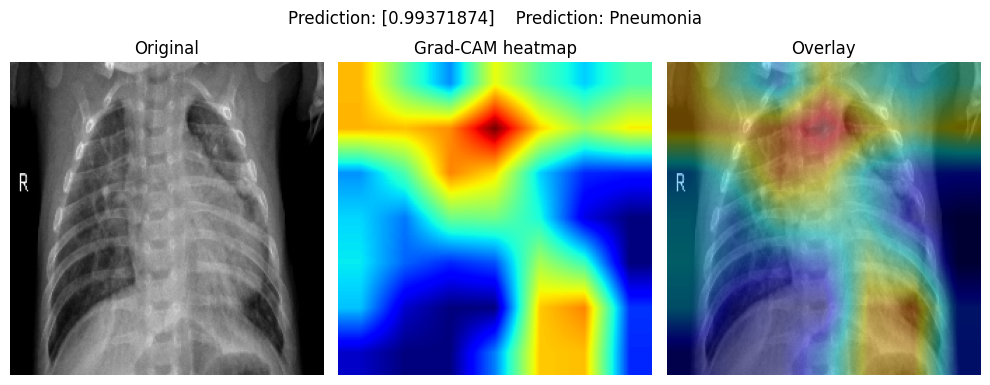

In [294]:
grad_cam_evaluateV2(
    img_path=img_path_pneumonia,
    model=pretrained_model
)

preds_from_conv:  tf.Tensor([[0.47859532]], shape=(1, 1), dtype=float32)
[[0.47859532]]


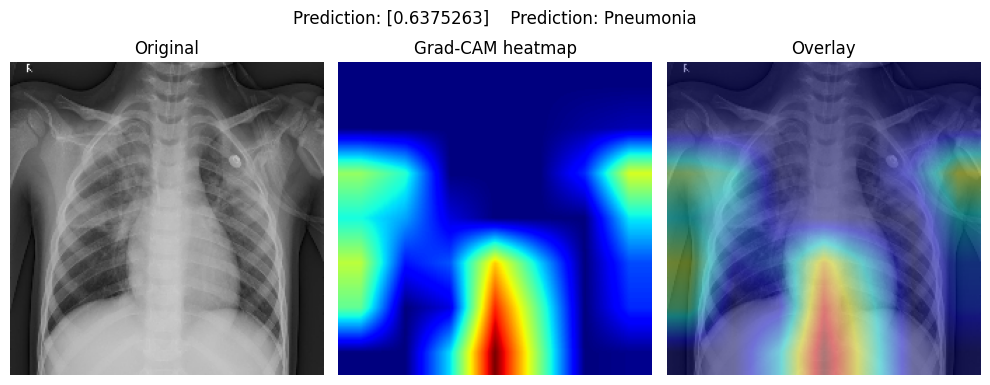

In [295]:
grad_cam_evaluateV2(
    img_path='../Data/chest_xray/test/PNEUMONIA/person3_virus_17.jpeg',
    model=pretrained_model
)

preds_from_conv:  tf.Tensor([[0.01514762]], shape=(1, 1), dtype=float32)
[[0.01514762]]


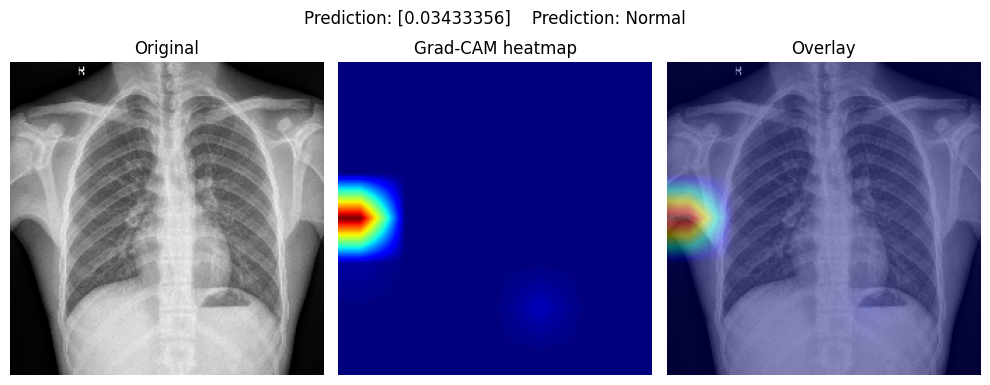

In [296]:
grad_cam_evaluateV2(
    img_path='../Data/chest_xray/test/NORMAL/IM-0025-0001.jpeg',
    model=pretrained_model
)


## Potential of the Model
1. Triage & prioritization
    - Flag high-risk X-rays so urgent cases are read earlier (reduce time-to-diagnosis).
    - Useful in high workload settings or EDs where rapid triage matters.

2. Second-reader / decision support
    - Provide a second opinion (probability + heatmap) to increase radiologist sensitivity for subtle pneumonia.
    - Helps less-experienced readers, e.g., in smaller hospitals or tele-radiology.

3. Quantification & monitoring
    - Track lesion probability and heatmap changes across serial studies to help assess progression or response to treatment.

4. Workflow automation
    - Auto-populate structured reporting fields (e.g., “probability of pneumonia: 0.87”) to reduce clerical load.

5. Data capture for research
    - Automatically tag studies for cohort creation (for clinical studies or QA).

Limitations & realistic expectations
- Not a replacement for radiologist judgement — should be human-in-the-loop.
- Performance may degrade on images from unseen hospitals, different X-ray machines, or different patient populations.
- Susceptible to dataset bias (age, positioning, comorbidities, portable AP vs PA view).
- Explainability (Grad-CAM) helps but is not a proof of correctness.


## Steps for Clinical Integration

### 1. Validation

- Collect diverse, labeled X-rays from multiple centers.
- Test on both internal and external data.
- Report AUC, sensitivity, specificity, PPV/NPV, calibration, and subgroup analysis.

### 2. Technical Setup

- Package model (SavedModel/ONNX).
- Provide inference API (REST/gRPC) for DICOM input, probability, and Grad-CAM overlay.
- Integrate with PACS/RIS, ensuring low latency (<3s).

### 3. Workflow Integration

- Start with silent mode (predictions not shown).
- Move to pilot phase where radiologists see results as optional overlays.
- Provide clear UI (probability + heatmap) and short training for clinicians.

### 4. Clinical Use & Monitoring

- Deploy gradually (single unit → multi-center).
- Track accuracy, bias across subgroups, and radiologist feedback.
- Recalibrate/retrain with new local data.
- Ensure compliance (HIPAA/GDPR, FDA/CE if needed).

The model can speed up pneumonia detection and support radiologists, but it needs staged validation, safe workflow integration, and continuous monitoring to be clinically useful.



